# **Understanding Vanishing Gradients**

As discussed in the main lecture, we train neural networks with gradient descent. This optimization algorithm requires computing the gradient using backpropagation. When we use deep neural networks, we have to backpropagate the gradient over long chains of computations.


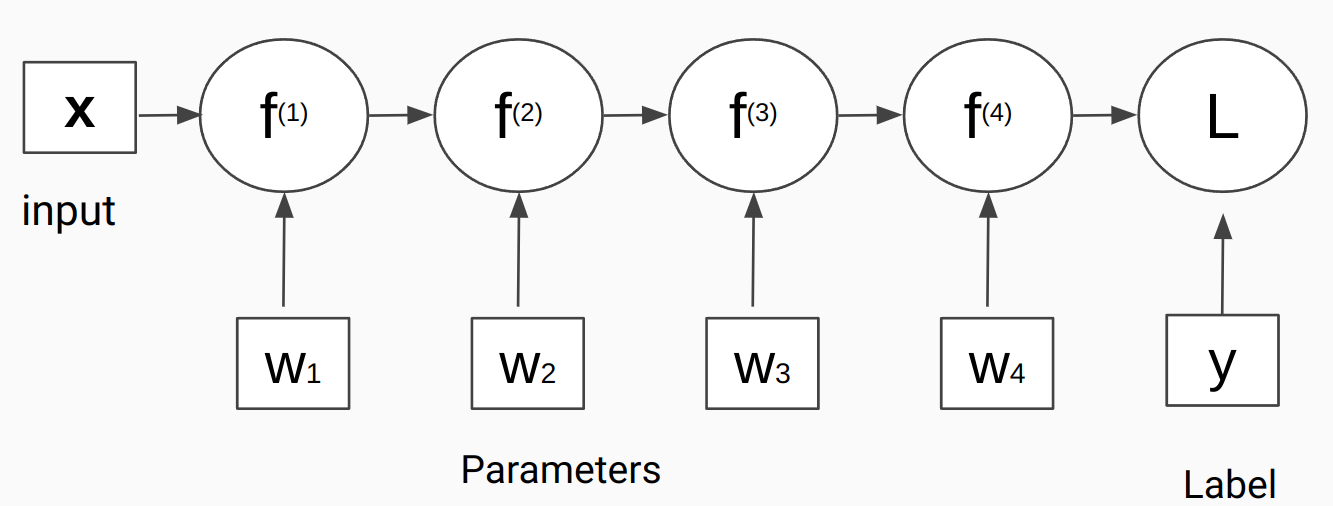

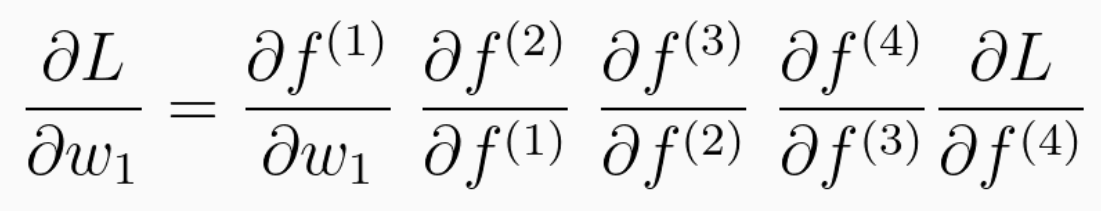

When backpropagating the gradient over long chains, two undesired outcomes are possible:
1. **Exploding Gradient**: after many "multiplications" (matrix multiplications in high dimensional spaces), the gradient gets bigger and bigger. At some point, it can get so big to cause numerical issues.

2. **Vanishing Gradient**: In this case, the gradient gets smaller and smaller. This issue happens more often in neural networks. When the gradient is small, the parameters of the neural networks are "stuck" as they don't change significantly during training. This issue mainly affects deep neural networks (neural networks with many layers) and recurrent neural networks (networks that are "deep" in the time axis). In the latter case, the vanishing gradient can prevent the network from learning long-term dependencies.

In this tutorial, we will understand better these issues.



Let's first import the libraries that we need:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(1)

## **Repeated multiplications**
Essentially, vanishing and exploding gradients are due to the many multiplications that we need to do when backpropagating the gradient over a long chain of computations.
Let's start with the simplest case, where every step in the computational graph has a single parameter only.

[0.7576315999031067, 0.21161475777626038, 0.08529540151357651, 0.06266520917415619, 0.0018349349265918136, 0.0014676885912194848, 0.0005828739376738667, 0.0004397037555463612, 0.00025041503249667585, 0.0001098765860660933, 7.017602911219001e-05, 3.681896851048805e-05, 2.513314575480763e-05, 7.66936682339292e-06, 3.5551013297663303e-06, 1.6175225709957886e-06, 9.259863418265013e-07, 4.611435997503577e-07, 4.321300082210655e-07, 2.833023131643131e-07, 8.889938385436835e-08, 1.760379575443949e-08, 7.32656202373505e-09, 2.0831587566050302e-09, 7.078068131605164e-10, 3.7084887938299005e-10, 2.959610889696762e-10, 2.2841339930579352e-10, 2.5638417170542604e-12, 2.0766099343566546e-12, 1.3283698143198852e-12, 1.2942011828540045e-12, 1.0742256693549446e-12, 4.772908346220399e-14, 1.1739348312143753e-15, 3.0385417040484464e-16, 2.853360449443955e-16, 1.1890395727160672e-16, 8.489501533908512e-17, 2.2721665427541507e-17, 2.2508285916727328e-17, 6.492532769712895e-18, 5.680722000121715e-18, 2.873

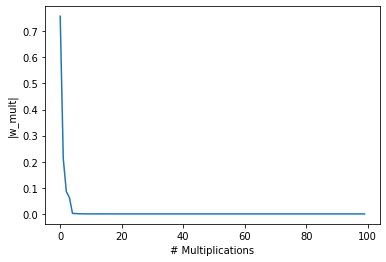

[4.789706707000732, 9.758771896362305, 38.15171432495117, 136.67881774902344, 120.82164001464844, 45.17837142944336, 221.3614501953125, 582.300537109375, 2453.607666015625, 7405.1806640625, 24467.138671875, 106857.6953125, 520454.34375, 437726.8125, 1231138.375, 5374711.0, 23170850.0, 93913688.0, 64866448.0, 45389612.0, 44848156.0, 126205896.0, 629977152.0, 580089920.0, 2223021824.0, 2481513984.0, 370888896.0, 730150720.0, 2877105920.0, 13870347264.0, 13140808704.0, 39981281280.0, 186198835200.0, 773960368128.0, 3140775837696.0, 13431783555072.0, 54819020603392.0, 172446443372544.0, 136310232711168.0, 54606386167808.0, 73961543041024.0, 163372553207808.0, 158082462121984.0, 539793771462656.0, 1767133423861760.0, 3417480244494336.0, 1.1827392892895232e+16, 3.912456649624781e+16, 1.575290924957696e+17, 6.590401228633539e+17, 1.0896360204937462e+18, 5.385595969335198e+18, 1.1907448145535042e+19, 2.8745889282296644e+19, 4.033042460664922e+18, 3.593277391973122e+18, 3.7351806375317996e+18, 

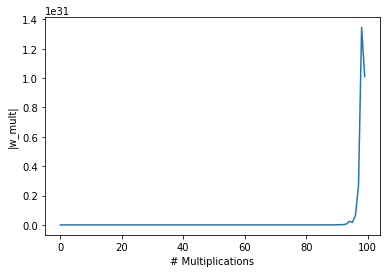

In [2]:
def mult_steps(steps=100, factor=1):
  w_mult_list = []
  w_mult=1
  for i in range(steps):
    w = torch.rand(1)*factor
    w_mult = w * w_mult
    w_mult_list.append(torch.abs(w_mult).item())

  print(w_mult_list)
  plt.plot(w_mult_list)
  plt.ylabel('|w_mult|')
  plt.xlabel('# Multiplications')
  plt.show()
  

# Multipling values (average below 1)
mult_steps(steps=100, factor=1)


# Multipling values (average above 1)
mult_steps(steps=100, factor=5)



When the numbers that we multiply are "on average" smaller than 1, we have vanishing gradients. If we multiply numbers that are often bigger than 1, we have exploding gradients.

In real neural networks, we have many parameters. This means that we need to multiply matrices or tensors. The same behavior happens with matrixes: when we multiply matrices containing large numbers we will have exploding gradients, otherwise vanishing gradients. In this case, what matters are the *eigenvalues* of the matrix. 

Matrices with eigenvalues that are not near the absolute value of 1 will either cause exploding or vanishing gradients.

Let's see an example:


[0.5821287631988525, 0.31647801399230957, 0.1977844089269638, 0.14347398281097412, 0.07927244901657104, 0.03651897609233856, 0.017061222344636917, 0.011540976352989674, 0.00668726721778512, 0.0030614228453487158, 0.0013690408086404204, 0.0003999398904852569, 0.00021291757002472878, 0.0001028729384415783, 6.344151915982366e-05, 4.6453798859147355e-05, 2.2635791538050398e-05, 1.3425058568827808e-05, 7.871955858718138e-06, 1.9119877379125683e-06, 1.2181054671600577e-06, 5.307303467816382e-07, 2.1915302284014615e-07, 1.3184555314182944e-07, 3.771918599682067e-08, 1.711582697794256e-08, 7.912671406984373e-09, 4.919415541593253e-09, 1.8855890182578605e-09, 1.127631543695884e-09, 4.483331206284191e-10, 2.109598884469932e-10, 1.1322395104818028e-10, 3.7873003344568446e-11, 1.676953888252175e-11, 8.244195257023357e-12, 2.328765652537257e-12, 1.187544962540088e-12, 6.145629794993002e-13, 3.5860287721060924e-13, 1.6470730486960183e-13, 5.744319272636342e-14, 2.2633291250841354e-14, 1.192630521250

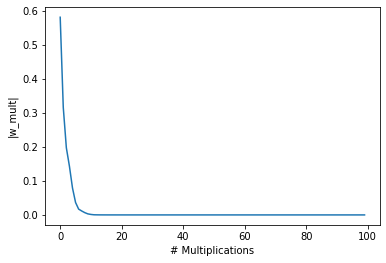

[2.329188346862793, 4.4048895835876465, 5.699765682220459, 9.945219039916992, 21.693296432495117, 38.591148376464844, 91.00077056884766, 173.1728515625, 194.4473876953125, 177.1224365234375, 316.9135437011719, 648.417236328125, 610.7288208007812, 335.20220947265625, 590.8764038085938, 627.2440185546875, 1225.590087890625, 1521.88232421875, 2160.651611328125, 2512.4169921875, 4455.05712890625, 5978.36279296875, 5810.3173828125, 3409.928466796875, 6592.95068359375, 8656.5791015625, 16422.251953125, 16523.57421875, 23201.3046875, 31722.11328125, 61106.921875, 112457.125, 251667.578125, 402963.5625, 360755.28125, 534849.75, 1024719.3125, 2248389.0, 3613848.5, 6788718.0, 8873936.0, 12455284.0, 17191128.0, 28584804.0, 23447232.0, 30183764.0, 12006335.0, 21145974.0, 40628620.0, 51744728.0, 122446240.0, 219221952.0, 164813584.0, 279441632.0, 652154560.0, 1358768128.0, 1645384064.0, 2756960256.0, 2437789696.0, 3683737600.0, 3693784832.0, 3749237504.0, 4861836288.0, 3654875904.0, 1134071808.0, 1

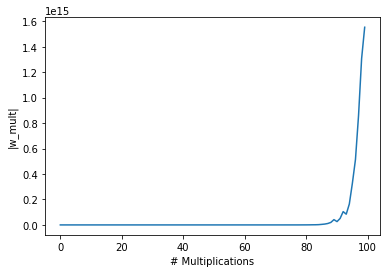

In [3]:
def mult_steps(steps=100, factor=1, dims=2):
  w_mult_list = []
  for i in range(steps):
    w = torch.rand(dims, dims)*factor
    if i==0:
      w_mult=w
    else:
      w_mult = torch.matmul(w,w_mult)
    # Storing the matrix norm (Frobenius)
    w_mult_list.append(torch.linalg.norm(w_mult).item())


  print(w_mult_list)
  plt.plot(w_mult_list)
  plt.ylabel('|w_mult|')
  plt.xlabel('# Multiplications')
  plt.show()
  

# Multipling small values
mult_steps(steps=100, factor=0.5)


# Multipling large values
mult_steps(steps=100, factor=1.5)

Note that if we multiply matrices with all eigenvalues equal to 1, we don't have vanishing and exploding gradients:

tensor([[1., 0.],
        [0., 1.]])
tensor([1., 1.])
[1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.4142135381698608, 1.414

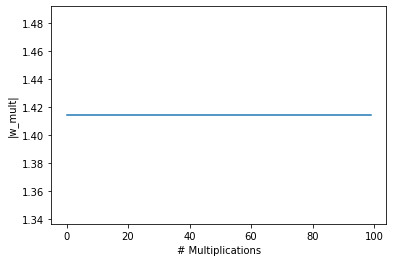

In [4]:
# Matrix with eigenvalues = 1
mat = torch.tensor([[1.0,0.0],[0.0,1.0]])
print(mat)

# Getting eigenvalues
L, V = torch.linalg.eig(mat)
print(L.real)

def mult_steps(steps=100, factor=1, dims=2):
  w_mult_list = []
  for i in range(steps):
    if i==0:
      w_mult=mat
    else:
      w_mult = torch.matmul(mat,w_mult)

    # Storing the matrix norm (Frobenius)
    w_mult_list.append(torch.linalg.norm(w_mult).item())


  print(w_mult_list)
  plt.plot(w_mult_list)
  plt.ylabel('|w_mult|')
  plt.xlabel('# Multiplications')
  plt.show()
  

# Multipling small values
mult_steps(steps=100, factor=0.5)


Unfortunately, this happens very rarely. In real cases, we cannot work with matrices whose all eigenvalues are equal to one.  

# **Real Task**
Let's now see if the aforementioned problems happen in a real machine learning problem. 

We will employ a deep neural network for digit classification using the MNIST dataset and we will analyze the gradient norms observed at the different layers. 



Let's download MNIST and read the data:

In [5]:
!gdown 1_yjmmCXLBNzEdRfSGh6ZeA4CFebRljOm # mnist_train

Downloading...
From: https://drive.google.com/uc?id=1_yjmmCXLBNzEdRfSGh6ZeA4CFebRljOm
To: /content/mnist_train.npz
100% 9.86M/9.86M [00:00<00:00, 127MB/s]


In [6]:
with np.load("mnist_train.npz") as data:
    X_trn = torch.from_numpy(data['X']).float()
    y_trn = torch.from_numpy(data['y']).long()

We now create a multi-layer perceptron (MLP). In the code below, users can specify the number of layers and hidden units, the type of activation function, as well as the type of normalization. We will explore what happens when changing the activation function and the normalization strategy.

In [7]:
class Block(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Block, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.bn = nn.BatchNorm1d(output_dim)
        self.ln = torch.nn.LayerNorm(output_dim)

    def forward(self, x, activation=torch.sigmoid, use_batchnorm=False):
        x = self.fc(x)
        if use_batchnorm:
          x = self.bn(x)
        x = activation(x)
        return x

class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super(Net, self).__init__()
        self.blocks=[]

        self.blocks.append(Block(input_dim,hidden_dim))

        for i in range(n_layers):
          self.blocks.append(Block(hidden_dim,hidden_dim))
        
        self.blocks.append(Block(hidden_dim, output_dim))
        self.blocks = nn.ModuleList(self.blocks)

    def forward(self, x, activation=torch.sigmoid, use_batchnorm=False, skip_connections=False):
        act = []
        for i, block in enumerate(self.blocks):
          x = block(x, activation=activation, use_batchnorm=use_batchnorm)
          if i>0 and i<len(self.blocks)-1:
            act.append(x)
          if skip_connections and i==len(self.blocks)-2:
            x = torch.stack(act).sum(dim=0)
        return x

loss = torch.nn.CrossEntropyLoss()

We can initialize a network with 10 layers of 100 neurons each. For now, we are using sigmoid activations and we are not applying any normalization to the latent representations:

In [8]:
n_layers = 10
net = Net(784,100, n_layers, 10)
net.zero_grad()

We can now the first forward step followed by gradient backpropagation:

In [9]:
probs = net(X_trn)
l = loss(probs, y_trn)
l.backward()

The following function will get the gradient norm observed at different layers:

In [10]:
def get_grad_norms(net):
  gradient_norms=[]

  n_layers = len(net.blocks)
  for i in range(1,n_layers-1):
    gradient = net.blocks[i].fc.weight.grad
    gradient_norm = torch.linalg.norm(gradient)
    gradient_norms.append(gradient_norm.item())

  gradient_norms = torch.tensor(gradient_norms)
  return gradient_norms

We can now plot the gradient norm over the 10 layers:

tensor([3.5135e-10, 8.0661e-10, 5.0179e-09, 3.7909e-08, 2.6047e-07, 1.7937e-06,
        1.2628e-05, 8.8966e-05, 6.5731e-04, 4.6907e-03])


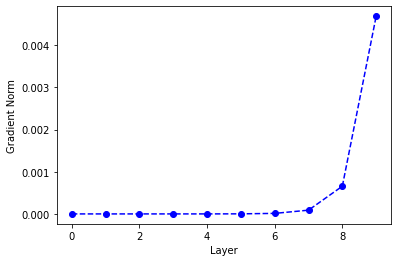

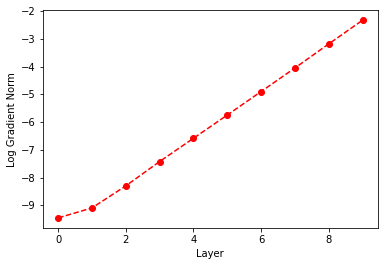

In [11]:
gradient_norms = get_grad_norms(net)

print(gradient_norms )

plt.plot(gradient_norms, "o--b")
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.show()

plt.plot(torch.log10(gradient_norms), "o--r")
plt.xlabel('Layer')
plt.ylabel('Log Gradient Norm')
plt.show()

We can clearly see the vanishing gradient issue (exploding gradient can happen but is rarer).

The gradient in the early layers is very small and tends to increase exponentially (the logarithmic plot is linear).

## *The role of activation functions*

The network above uses sigmoid activations. This was the dominant approach for many years before the recent raise of deep learning. Today, we know that this is not a good choice for deep neural networks as the two saturation points of the sigmoid cause the gradient to vanish very quickly.



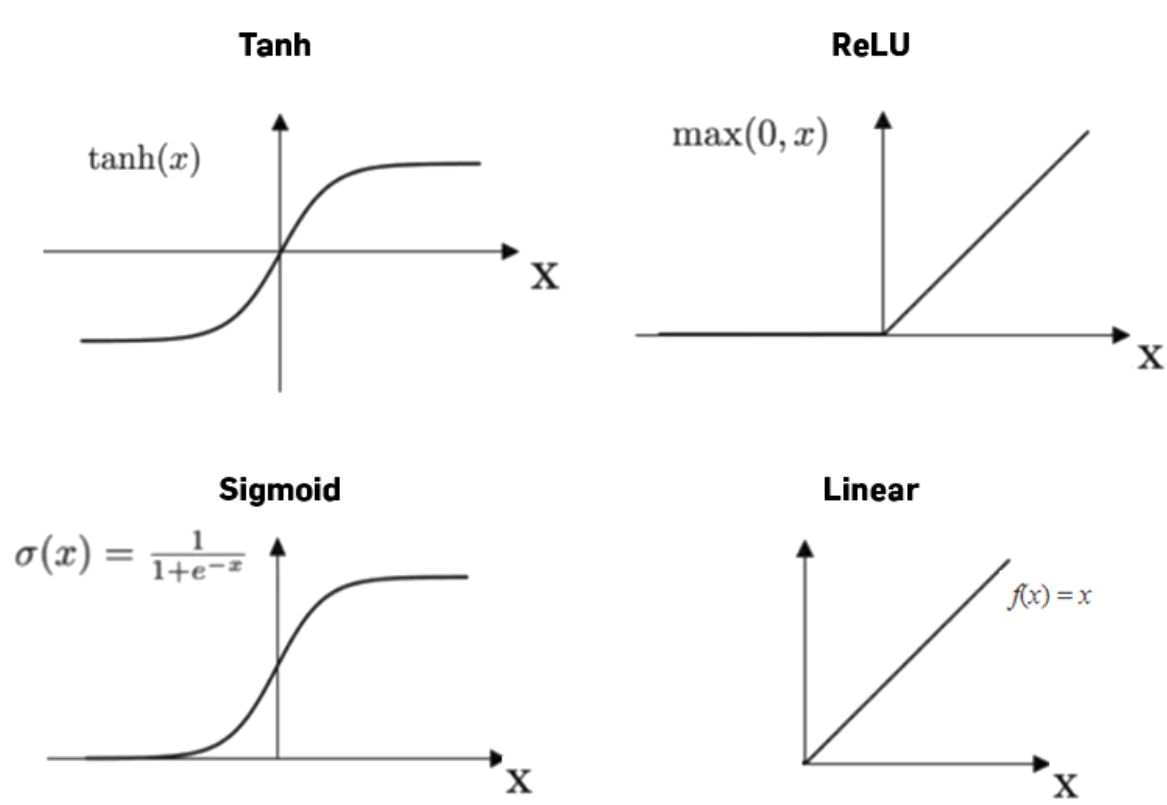

Let's see what happens with ReLU:

In [12]:
net.zero_grad()
probs = net(X_trn, activation=F.relu)
l = loss(probs, y_trn)
l.backward()

gradient_norms_relu = get_grad_norms(net)

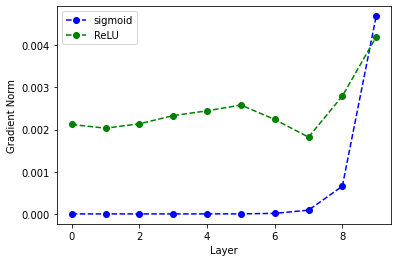

In [13]:
plt.plot(gradient_norms, "o--b", label="sigmoid")
plt.plot(gradient_norms_relu, "o--g", label="ReLU")
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

When using ReLU and LeakyReLU, we observe a significant improvement in the gradient vanishing issue. The latter activations don't have two saturation points. Another option is to use, LeakyReLU. They are normally slightly better than ReLU because the gradient is not zero for negative input values.
 

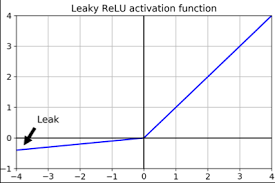

In [14]:
net.zero_grad()
probs = net(X_trn, activation=F.leaky_relu)
l = loss(probs, y_trn)
l.backward()

gradient_norms_leaky_relu = get_grad_norms(net)

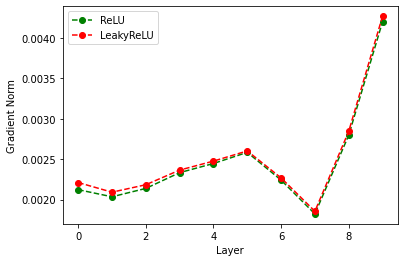

In [15]:
plt.plot(gradient_norms_relu, "o--g", label="ReLU")
plt.plot(gradient_norms_leaky_relu, "o--r", label="LeakyReLU")
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

The difference is actually tiny, but still a bit better than ReLU.

## Role of Normalization
The normalization of the internal hidden representations of the neural networks also helps significantly to counteract gradient vanishing problems.

Let's see what happens when adding batch normalization:

In [16]:
net.zero_grad()
probs = net(X_trn, activation=F.leaky_relu, use_batchnorm=True)
l = loss(probs, y_trn)
l.backward()
gradient_norms_bn = get_grad_norms(net)

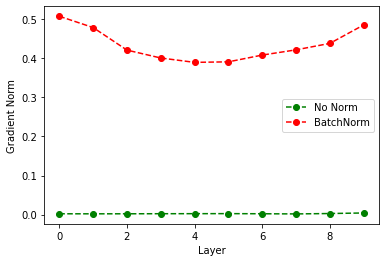

In [17]:
plt.plot(gradient_norms_leaky_relu, "o--g", label="No Norm")
plt.plot(gradient_norms_bn, "o--r", label="BatchNorm")
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

The batch normalization helps significantly: even after 10 hidden layers, the norm of the gradient stays high.

## The role of skip connections

Another trick to mitigate vanishing gradient consists of adding skip connections. There are different types of skip connections. In this case, we sum up all the previous layers in the final. one. 

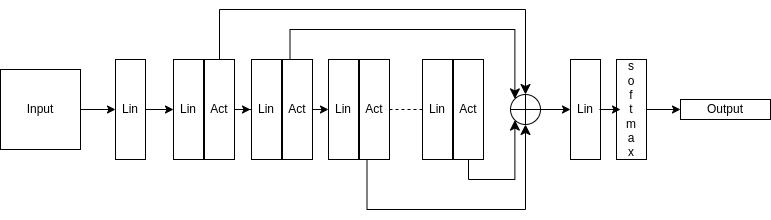

For all types of skip connections, the trick is the same: *shortening the path between the parameters and the final loss*. This way we have at least one path where the number of matrix multiplications is small.

To make the effect of shortcuts more evident, we will disable batch norm.

In [18]:
net.zero_grad()
probs = net(X_trn, activation=F.leaky_relu, skip_connections=False)
l = loss(probs, y_trn)
l.backward()
gradient_norms_noskip = get_grad_norms(net)

In [19]:
net.zero_grad()
probs = net(X_trn, activation=F.leaky_relu,  skip_connections=True)
l = loss(probs, y_trn)
l.backward()
gradient_norms_skip = get_grad_norms(net)

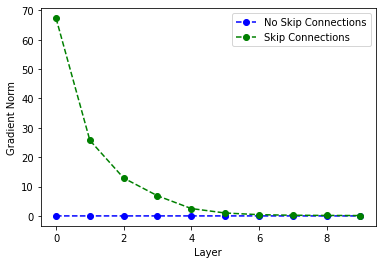

In [20]:
plt.plot(gradient_norms_noskip, "o--b", label="No Skip Connections")
plt.plot(gradient_norms_skip, "o--g", label="Skip Connections")
plt.xlabel('Layer')
plt.ylabel('Gradient Norm')
plt.legend()
plt.show()

You can see that with this type of skip connections, we significantly improve the vanishing gradient. It even looks like now we have larger gradients in the first layers. 

*How this is possible?* 

If you take a look, in the first layers we now have many more possible gradient paths. This number grows very fast when increasing the number of layers. As the total gradient is the sum of the contributions of all the paths, it is normal now to have a larger gradient for the first layers.